In [1]:
%matplotlib inline
import os, math, sys
import numpy as np
import nibabel as nb 
from numpy import mean, std
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind, mannwhitneyu, wilcoxon, spearmanr,pearsonr, fisher_exact,kstest
from scipy.stats import ks_2samp, kstest, anderson, anderson_ksamp, levene
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as ss 
from outliers import smirnov_grubbs as grubbs
from matplotlib.colors import ListedColormap
pd.options.display.max_columns = 999
sns.set_style('white')

workspace_dir  = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSMv3/dataframes'
#workspace_dir  = '/scr/malta3/workspace/project_iron/phenotypic'
pheno_dir      = os.path.join(workspace_dir, 'phenotypic')
clinical_dir   = os.path.join(workspace_dir, 'DF_clinical')
save_fig_dir   = '/Users/kanaan/Google Drive/TS-EUROTRAIN/Papers/2016_QSM_paper/Figures_python_v4'


sys.path.append('/Users/kanaan/SCR/Github/Tourettome')
from plotting.cmaps import *

/Users/kanaan/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/kanaan/SCR/Github/Tourettome/plotting/cmaps.py:6: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/kanaan/anaconda/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/kanaan/anaconda/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/kanaan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    ap

# Grab QCd dataframes

In [2]:
def get_df(popname):
    df = pd.read_csv(os.path.join(pheno_dir, 'df_%s_qc.csv'%popname),index_col = 0)
    return df 

controls = get_df('controls')
patients = get_df('patients')


In [3]:
# some stat funcs 
def cohen_d(df1,df2, metabolite):
    x = df1[metabolite].dropna(axis=0)
    y = df2[metabolite].dropna(axis=0)
    return (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)

def reject_outliers(data, m=3):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

def grubbs_outliers(df, measure, alpha = 0.05):
    from outliers import smirnov_grubbs as grubbs
    return [str(i) for i in df.index if i not in grubbs.test(df[measure], alpha).index] 

def gESD_outliers(df, measure, maxOLs =10, alpha = 0.05):
    from PyAstronomy import pyasl
    index = pyasl.generalizedESD(df[measure],maxOLs = maxOLs, alpha =alpha, fullOutput=True)[1]
    return [df.index[i] for i in index] 

def calc_confidence_95(df1,df2, metabolite):
    import numpy as np, statsmodels.stats.api as sms
    X1 = df1[metabolite].dropna(axis=0)
    X2 = df2[metabolite].dropna(axis=0)
    cm = sms.CompareMeans(sms.DescrStatsW(X1), sms.DescrStatsW(X2))
    return cm.tconfint_diff(usevar='pooled')


In [21]:

def make_statistical_comparison(df_controls, df_patients, stat, measures, grubbs = False, ESD = False):
    df_controls['Group'] = 0
    df_patients['Group'] = 1
    cols = ['N','Controls', 'Patients','Levene','KS', 'KS_C', 'KS_P','D','CI_95', 'Statistic', 'p_val', 'p_fdr', 'sig']
    dfs = pd.DataFrame(index= cols, columns=measures)
    
    if grubbs:
        for measure in measures:
            grubbs_controls = grubbs_outliers(df_controls, measure)
            grubbs_patients = grubbs_outliers(df_patients, measure)
            print 'GRUBBS OUTLIERS=', measure, grubbs_controls, grubbs_patients
            for subject in grubbs_controls :
                df_controls.loc[subject,measure] = np.nan
            for subject in grubbs_patients :
                df_patients.loc[subject,measure] = np.nan
    elif ESD:
        for measure in measures:
            grubbs_controls = gESD_outliers(df_controls, measure)
            grubbs_patients = gESD_outliers(df_patients, measure)
            print 'gESD OUTLIERS=', measure, grubbs_controls, grubbs_patients
            for subject in grubbs_controls :
                df_controls.ix[subject,measure] = np.nan
            for subject in grubbs_patients :
                df_patients.ix[subject,measure] = np.nan
        
    df = pd.concat([df_controls, df_patients])
    for measure in measures:
        if stat == 'MR':
            formula = '%s ~ Group + Age + Gender + EFC_MAG + QI1_MAG'%measure
            model   = smf.ols(formula=formula, data = df)
            fit     = model.fit()
            p_val   = np.round(fit.pvalues[1],5)
            t_val   = np.round(fit.tvalues[1],3)
        
        elif stat == 'MW':
            
            t_val, p_val = mannwhitneyu(df_controls[measure].dropna(), df_patients[measure].dropna())
            
        elif stat == 'TT':
            t_val, p_val = ttest_ind(df_controls[measure].dropna(), df_patients[measure].dropna())
            
        ci95 = calc_confidence_95(df_controls, df_patients, measure)
        xval = 1
        npr  = 4
        dfs.loc['N'][measure] = len(df_controls[measure].dropna()), len(df_patients[measure].dropna())
        dfs.loc['Levene'][measure] = np.round(levene(df_controls[measure].dropna(), df_patients[measure].dropna())[1],5)
        dfs.loc['KS'][measure] = np.round(ks_2samp((df_controls[measure].dropna()), 
                                                  (df_patients[measure].dropna()))[1], 5)
        dfs.loc['KS_C'][measure] = np.round(kstest((df_controls[measure].dropna()), 'norm')[1],5)
        dfs.loc['KS_P'][measure] = np.round(kstest((df_patients[measure].dropna()), 'norm')[1],25)
        dfs.loc['D'][measure]    = cohen_d(df_controls, df_patients,measure)
        dfs.loc['Controls'][measure] = '%s±%s'%(xval*np.round(np.mean(df_controls[measure]),npr), 
                                              xval*np.round(np.std(df_controls[measure]), npr))   
        dfs.loc['Patients'][measure] = '%s±%s'%(xval*np.round(np.mean(df_patients[measure]),npr), 
                                              xval*np.round(np.std(df_patients[measure]), npr))   
        dfs.loc['D'][measure]    = np.round(cohen_d(df_controls, df_patients,measure),2)
        dfs.loc['CI_95'][measure]= '%s to %s'%(np.round(ci95[0],2), np.round(ci95[1],5))
        dfs.loc['Statistic'][measure]= np.round(t_val,4)        
        dfs.loc['p_val'][measure]    = np.round(p_val,5)
        
        if p_val < 0.05:
            print measure, 'p =', np.round(p_val,3)
    
    dfs = dfs.T.sort_values('p_val')
    dfs['p_fdr'] = fdrcorrection0(dfs.p_val)[1]
    dfs['sig'] = fdrcorrection0(dfs.p_val)[0]
    return dfs, df 

In [22]:
measures  = ['BG', 'BS', 'ALL']

X, XX = make_statistical_comparison(controls, patients, 'MW', measures = measures, ESD=0)
X.drop(['Levene', 'KS', 'KS_C', 'KS_P'],axis = 1)

BG p = 0.004
BS p = 0.011
ALL p = 0.006


,N,Controls,Patients,D,CI_95,Statistic,p_val,p_fdr,sig
BG,"(26, 23)",24.7406±14.5895,13.5298±13.202,0.79,3.01 to 19.41642,167,0.00421,0.008445,True
ALL,"(26, 23)",70.4926±18.4461,56.6489±18.1682,0.74,3.07 to 24.61333,172,0.00563,0.008445,True
BS,"(26, 23)",116.2446±25.0488,99.7681±26.2989,0.63,1.4 to 31.55438,184,0.0109,0.0109,True


In [23]:
measures = [ 'Caud_Puta' ,'Pall','RN', 'SN', 'STN', 'DN', ] # 'Thal',
#measures = ['R_'+ measure for measure in measures ]
X, XX = make_statistical_comparison(controls, patients, 'MW', measures = measures, ESD=0)
X

Caud_Puta p = 0.009
Pall p = 0.021
SN p = 0.032
STN p = 0.003
DN p = 0.016


,N,Controls,Patients,Levene,KS,KS_C,KS_P,D,CI_95,Statistic,p_val,p_fdr,sig
STN,"(26, 23)",69.2979±33.1601,42.0377±31.0776,0.70772,0.01997,0,0,0.83,8.33 to 46.19301,159,0.0026,0.0156,True
Caud_Puta,"(26, 23)",17.4845±15.6499,6.3751±13.4218,0.66592,0.04969,0,1.05439e-08,0.75,2.5 to 19.72127,180,0.0088,0.0264,True
DN,"(26, 23)",72.1254±31.2401,51.4753±39.3724,0.4134,0.0223,0,0,0.57,-0.1 to 41.40103,191,0.01564,0.03128,True
Pall,"(26, 23)",87.5796±19.3549,75.1667±19.9007,0.89417,0.20526,0,0,0.62,0.88 to 23.94505,197,0.02101,0.031515,True
SN,"(26, 23)",123.9856±24.6577,110.0428±31.1933,0.7203,0.08543,0,0,0.49,-2.47 to 30.35744,206,0.03193,0.038316,True
RN,"(26, 23)",116.3194±46.6104,97.8815±34.4964,0.18717,0.14067,0,0,0.44,-5.89 to 42.76204,232,0.09139,0.09139,False


In [24]:
measures = [ 'STR3_MOTOR', 'STR3_EXEC', 'STR3_LIMBIC']
X, XX = make_statistical_comparison(controls, patients, 'MW', measures = measures, ESD=0)
X 

STR3_MOTOR p = 0.023
STR3_EXEC p = 0.01
STR3_LIMBIC p = 0.016


,N,Controls,Patients,Levene,KS,KS_C,KS_P,D,CI_95,Statistic,p_val,p_fdr,sig
STR3_EXEC,"(26, 23)",8.6945±14.4642,-2.1561±13.2351,0.67357,0.02149,0,2.36335e-06,0.77,2.68 to 19.02408,182,0.0098,0.02311,True
STR3_LIMBIC,"(26, 23)",-2.3843±16.0643,-13.2568±15.0085,0.92216,0.05485,0,3.33067e-15,0.68,1.71 to 20.03195,191,0.01564,0.02311,True
STR3_MOTOR,"(26, 23)",18.8783±22.7229,6.2553±18.9297,0.53435,0.11855,0,1.8261e-07,0.59,0.26 to 24.98721,199,0.02311,0.02311,True


# Lets plot QSM 


In [29]:
measures = ['RN','SN','STN','Caud_Puta','Pall','DN']
Brainstem =  ['SN','STN',]
Basalganglia = ['Caud_Puta','Pall','DN']
red = ['RN']

lims = {'cor_x': (45, 160), 'cor_y': (140,10), 'ax_x': (35, 170), 'ax_y':(200,50)}
Zcuts = { 'RN':41, 'STN':130, 'SN':130, 'Pall':64, 'Caud_Puta': 64, 'DN':20}

sns.set(font_scale=2)
sns.set_style('darkgrid', {"xtick.direction": "in","ytick.direction": "in"})
palette = sns.color_palette("hls", 24)

def make_split_plot(measures,df1,df2, save = 0 ):
    fig = plt.figure()
    fig.set_size_inches(40, 20)
    fig.subplots_adjust(left=None, bottom=None, 
                        right=None, top=None, wspace=None, hspace=None)

    #left  = 0.125  # the left side of the subplots of the figure
    #right = 0.9    # the right side of the subplots of the figure
    #bottom = 0.1   # the bottom of the subplots of the figure
    #top = 0.9      # the top of the subplots of the figure
    #wspace = 0.2   # the amount of width reserved for blank space between subplots
    #hspace = 0.2   # the amount of height reserved for white space between subplots

    x = 1
    for i, measure in enumerate(measures): 
        c = i 
        c += i*3
        print measure, c 
        ax1 = plt.subplot2grid((2,6),(1,i), colspan=1,rowspan=1)
        data = [df1[measure]*x, df2[measure]*x] 
        df = pd.concat([make_split_df(df1, 'Controls', measure,'Left'),make_split_df(df1, 'Controls', measure,'Right'),
                        make_split_df(df2, 'Patients', measure,'Left'),make_split_df(df2, 'Patients', measure,'Right')])
        g = sns.stripplot(data=data, ax = ax1, color = palette[c+2] ,
                          jitter= 0.1, size = 10, linewidth=1)
        g = sns.pointplot(data=data, ax = ax1, color = palette[c+2] ,
                          linestyles=['--'], markers=['o'], )        
        g = sns.violinplot(x='Population', y = measure, hue= 'Hemisphere', split=1,  
                           data=df, ax = ax1, inner= 'quart',
                           palette ={'Left': palette[c],'Right': palette[c+1] })
        g.set(xticklabels=[])  
        g.set(xlabel=' ',ylabel=' ')
        plt.legend(loc='upper left')
        #g.legend_.remove()
        ####################################################
        
        qsm, uni, l, r = return_qsm_data('BATP', measure)
        qsm2, uni2, l2, r2 = return_qsm_data('PAHT', measure)
        Zcut =Zcuts[measure]
        ax2 = plt.subplot2grid((2,6),(0,i), colspan=1,rowspan=1)
        
        if measure in Brainstem:
            print measure
            ax2.imshow(np.rot90(qsm[Zcut,:,:]), interpolation= None, alpha = 1,vmin = -.25, vmax = 0.25)
            ax2.imshow(np.rot90(uni[Zcut,:,:]), interpolation= None, alpha = 0.5)
            ax2.imshow(np.rot90(l[Zcut,:,:]), interpolation= None, cmap= ListedColormap(palette[c]))
            ax2.imshow(np.rot90(r[Zcut,:,:]), interpolation= None, cmap= ListedColormap(palette[c+1]))
            ax2.set_xlim(lims['cor_x'][0],lims['cor_x'][1])
            ax2.set_ylim(lims['cor_y'][0],lims['cor_y'][1])
        elif measure in red:
            ax2.imshow(qsm2[:,:,Zcut], interpolation= None, alpha = 1,vmin = -.25, vmax = 0.25)
            ax2.imshow(uni2[:,:,Zcut], interpolation= None, alpha = 0.5)
            ax2.imshow(l2[:,:,Zcut], interpolation= None, cmap= ListedColormap(palette[c]))
            ax2.imshow(r2[:,:,Zcut], interpolation= None, cmap= ListedColormap(palette[c+1]))
            ax2.set_xlim(35, 170)
            ax2.set_ylim(200,50)
            
        elif measure in Basalganglia:
            print measure
            ax2.imshow(qsm[:,:,Zcut], interpolation= None, alpha = 1,vmin = -.25, vmax = 0.25)
            ax2.imshow(uni[:,:,Zcut], interpolation= None, alpha = 0.5)#,vmin = -.3, vmax = 0.
            ax2.imshow(l[:,:,Zcut], interpolation= None, cmap= ListedColormap(palette[c]))
            ax2.imshow(r[:,:,Zcut], interpolation= None, cmap= ListedColormap(palette[c+1]))
            if measure == 'DN':
                ax2.set_xlim(35, 170)
                ax2.set_ylim(230,80)
            else:    
                ax2.set_xlim(lims['ax_x'][0],lims['ax_x'][1])
                ax2.set_ylim(lims['ax_y'][0],lims['ax_y'][1])
        ax2.set_xticklabels = []
        ax2.set_yticklabels = []
        ax2.axes.get_yaxis().set_visible(False)
        ax2.axes.get_xaxis().set_visible(False)
        ax2.grid(False)
        #ax2.tick_params(axis='x', labelsize=5)
        #ax2.tick_params(axis='y', labelsize=25)
        plt.xticks(fontsize=12, weight='bold')
        plt.yticks(fontsize=12, weight='bold')
        
    plt.tight_layout()
    if save:
        fig.savefig(os.path.join(save_fig_dir, 'stats_all_splitv2.png'),
                    dpi = 300, bbox_inches='tight', transparent = False)


In [10]:
# lets test some clustering

In [11]:
features1 = ['STR3_MOTOR', 'STR3_LIMBIC', 'STR3_EXEC', 'STN','SN','THA' ]
features2 = ['STR_Gln', 'STR_Glu', 'STR_Glx']
features = features1+features2

In [12]:
dfX = pd.concat([controls,patients])
dfX = dfX.drop([i for i in dfX.columns if i not in features], axis = 1 ).dropna()
dfX = pd.DataFrame(preprocessing.scale(dfX), columns=dfX.columns, index = dfX.index)
#dfX = pd.DataFrame(preprocessing.scale(dfX))


(array([ 0.5,  3.5,  6.5,  9.5, 12.5, 15.5, 18.5, 21.5, 24.5, 27.5, 30.5,
        33.5, 36.5]), <a list of 13 Text yticklabel objects>)

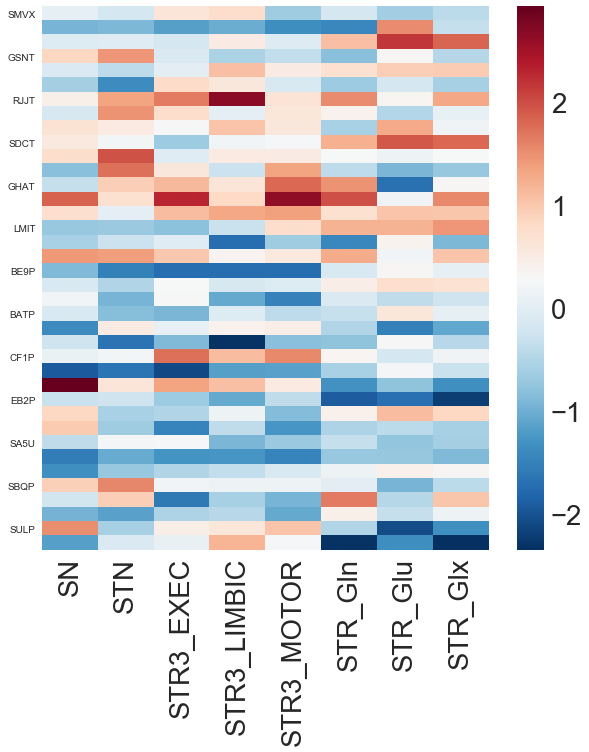

In [13]:
f = plt.figure(figsize = (10,10))
sns.heatmap(dfX, cmap='RdBu_r')
plt.yticks(size=10)

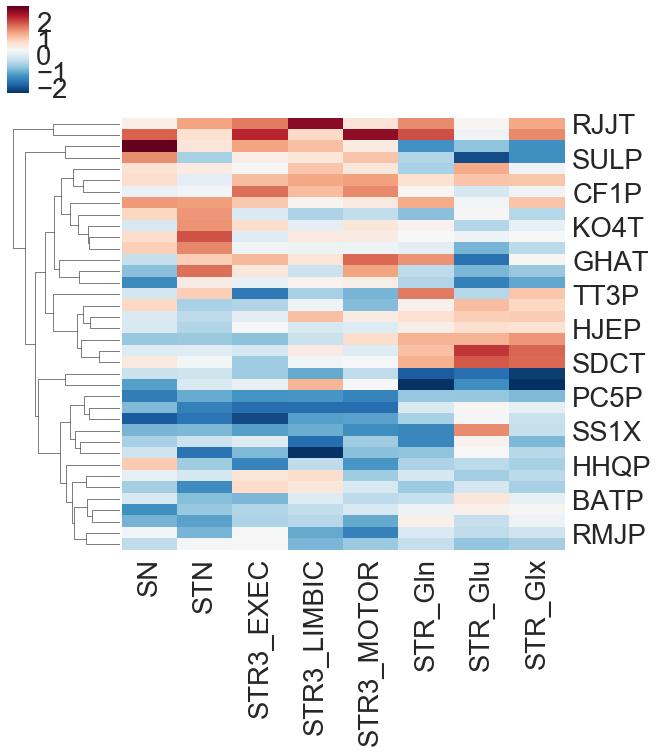

In [14]:
cg = sns.clustermap(dfX,  figsize=(10,10),cmap='RdBu_r', row_cluster=1, col_cluster=0, method='average')


In [15]:
from sklearn.cluster import AgglomerativeClustering

df =dfX.copy(deep=True)
clust = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
clust.fit(df)
    
df_L = df.copy(deep=True)
df_L['label'] = clust.labels_
df_L

,SN,STN,STR3_EXEC,STR3_LIMBIC,STR3_MOTOR,STR_Gln,STR_Glu,STR_Glx,label
SMVX,0.053434,-0.183212,0.631242,0.783244,-0.646127,-0.170163,-0.626568,-0.418719,1
SS1X,-0.934684,-0.899304,-1.156594,-1.025561,-1.359425,-1.423377,1.535564,-0.343768,1
STQT,-0.070719,-0.029625,-0.163767,0.510985,-0.042938,1.096256,2.189827,1.836624,0
GSNT,0.865578,1.467237,-0.091994,-0.551493,-0.351593,-0.817816,0.331281,-0.453529,0
PAHT,-0.103789,-0.398127,0.014572,1.095528,0.503994,0.719922,0.935503,0.971873,0
LL5T,-0.599038,-1.377616,0.794196,0.592469,-0.132117,-0.677942,-0.164482,-0.581299,1
RJJT,0.450009,1.360825,1.661896,2.684881,0.657859,1.543918,0.340133,1.306913,0
KO4T,-0.158577,1.486322,0.769283,0.039223,0.614889,0.405897,-0.483622,0.076687,0
HM2X,0.682151,0.533187,0.305828,1.035927,0.595766,-0.573689,1.291712,0.175024,0
SDCT,0.553841,0.225520,-0.676624,0.206369,0.266042,1.223670,1.933400,1.811943,0


In [16]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline

# We'll define a function to draw a nice plot of an SVM
def plot_svc(svc, X, y, h=0.02, pad=0.25):
    x_min, x_max = X[:, 0].min()-pad, X[:, 0].max()+pad
    y_min, y_max = X[:, 1].min()-pad, X[:, 1].max()+pad
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.2)

    plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=mpl.cm.Paired)
    # Support vectors indicated in plot by vertical lines
    sv = svc.support_vectors_
    plt.scatter(sv[:,0], sv[:,1], c='k', marker='x', s=100, linewidths='1')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()
    print('Number of support vectors: ', svc.support_.size)